In [14]:
%matplotlib widget

from pathlib import Path

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from carwatch_analysis.saliva_helper import import_cortisol_raw, import_cortisol_features, analysis_saliva_features

import biopsykit as bp
from biopsykit.stats import StatsPipeline

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

import pingouin as pg
from pingouin import mixed_anova, rm_anova

## Read files

In [3]:
export_path = Path("../..").joinpath("exports")

### Features

In [4]:
cort_feat = pd.read_csv(export_path.joinpath('cortisol_features_app_cleaned.csv'))
cort_feat.head()

C:\Users\Luca\anaconda3\envs\fp\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,subject,condition,chronotype,MEQ,night,wakeup_source,weekend,date,wakeup_hour,log_mode,saliva_feature,cortisol
0,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,naive_sr_only,cortisol_auc_g,633.675000
1,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,naive_sr_only,cortisol_auc_i,16.875000
2,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,naive_sr_only,cortisol_max_inc,2.090000
3,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,naive_sr_only,cortisol_slopeS0S3,-0.001333
4,AB31R,Spontaneous,Intermediate,56.0,0,Spontaneous,Weekday,2020-01-08,5,naive_sr_only,cortisol_slopeS0S4,-0.034500


### Samples

In [5]:
# app and self_report

cort_samples = pd.read_csv(export_path.joinpath('cortisol_samples_app_cleaned.csv'))
cort_samples.head()

,subject,condition,chronotype,MEQ,night,wakeup_source,weekend,date,wakeup_hour,log_mode,wakeup_self_report,wakeup_app,sample,cortisol,time,time_diff
0,BC05R,Spontaneous,Intermediate,47.0,0,Spontaneous,Weekend,2019-12-07,7,self_report,07:31:00,07:31:16,S0,5.88,0.0,0.0
1,BC05R,Spontaneous,Intermediate,47.0,0,Spontaneous,Weekend,2019-12-07,7,self_report,07:31:00,07:31:16,S1,12.54,15.0,0.0
2,BC05R,Spontaneous,Intermediate,47.0,0,Spontaneous,Weekend,2019-12-07,7,self_report,07:31:00,07:31:16,S2,12.91,30.0,0.0
3,BC05R,Spontaneous,Intermediate,47.0,0,Spontaneous,Weekend,2019-12-07,7,self_report,07:31:00,07:31:16,S3,12.30,45.0,0.0
4,BC05R,Spontaneous,Intermediate,47.0,0,Spontaneous,Weekend,2019-12-07,7,self_report,07:31:00,07:31:16,S4,10.38,60.0,0.0


### Number of samples (nights)

In [6]:
count = pd.DataFrame(cort_samples.groupby('log_mode').size()/5)
count.rename(columns={0:'number of total nights'}, inplace=True)
count

,number of total nights
log_mode,
app,50.0
naive,50.0
naive_sr_only,92.0
self_report,50.0
self_report_only,92.0


### Boxplots of differences

Text(0.5, 1.0, 'app')

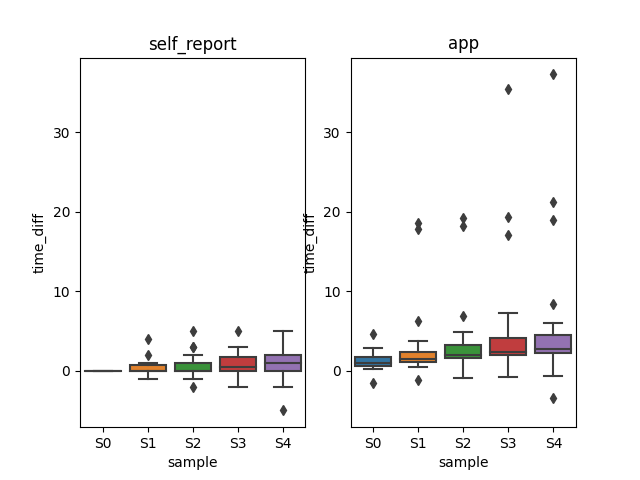

In [7]:
# self_report and app

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.sharey(ax2)

sns.boxplot(x='sample', y='time_diff', data=cort_samples.loc[cort_samples['log_mode']=='self_report'], ax=ax1)
ax1.set_title('self_report')
sns.boxplot(x='sample', y='time_diff', data=cort_samples.loc[cort_samples['log_mode']=='app'], ax= ax2)
ax2.set_title('app')

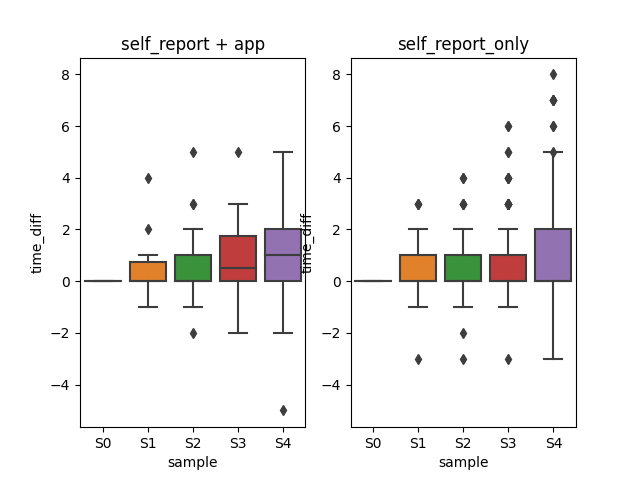

In [8]:
# self_report and self_report_only

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.sharey(ax2)

sns.boxplot(x='sample', y='time_diff', data=cort_samples.loc[cort_samples['log_mode']=='self_report'], ax=ax1)
ax1.set_title('self_report + app')
sns.boxplot(x='sample', y='time_diff', data=cort_samples.loc[cort_samples['log_mode']=='self_report_only'], ax= ax2)
ax2.set_title('self_report_only')

plt.show()

### Histogram of last time digit

In [9]:
all_sr = cort_samples['wakeup_self_report']
spont = cort_samples.loc[cort_samples['condition']=='Spontaneous']['wakeup_self_report']
known_alarm = cort_samples.loc[cort_samples['condition']=='Known Alarm']['wakeup_self_report']
unknown_alarm = cort_samples.loc[cort_samples['condition']=='Unknown Alarm']['wakeup_self_report']

all_sr = pd.to_timedelta(all_sr).apply(lambda x: x.seconds / 60 % 10)
spont = pd.to_timedelta(spont).apply(lambda x: x.seconds / 60 % 10)
known_alarm = pd.to_timedelta(known_alarm).apply(lambda x: x.seconds / 60 % 10)
unknown_alarm = pd.to_timedelta(unknown_alarm).apply(lambda x: x.seconds / 60 % 10)

In [10]:
all_app = cort_samples['wakeup_app']
spont_app = cort_samples.loc[cort_samples['condition']=='Spontaneous']['wakeup_app']
known_alarm_app = cort_samples.loc[cort_samples['condition']=='Known Alarm']['wakeup_app']
unknown_alarm_app = cort_samples.loc[cort_samples['condition']=='Unknown Alarm']['wakeup_app']

all_app = pd.to_timedelta(all_app).apply(lambda x: x.seconds / 60 % 10)
spont_app = pd.to_timedelta(spont_app).apply(lambda x: x.seconds / 60 % 10)
known_alarm_app = pd.to_timedelta(known_alarm_app).apply(lambda x: x.seconds / 60 % 10)
unknown_alarm_app = pd.to_timedelta(unknown_alarm_app).apply(lambda x: x.seconds / 60 % 10)

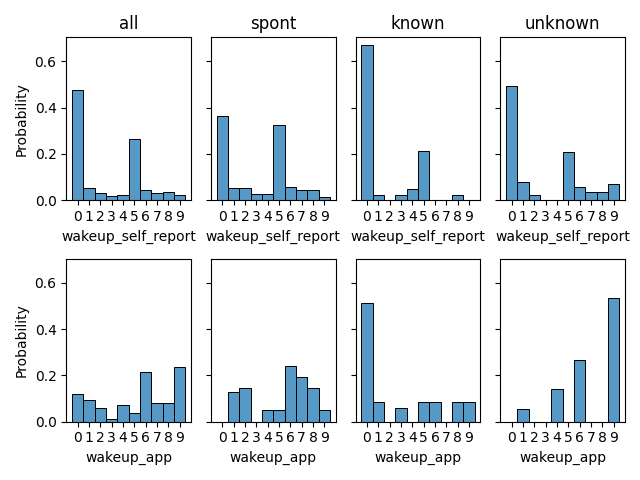

In [11]:
fig, (axs0,axs1) = plt.subplots(2, 4, sharey = True)


for ax in axs0:
    ax.set_xticks(np.arange(0,10))
for ax1 in axs1:
    ax1.set_xticks(np.arange(0,10)) 

sns.histplot(all_sr,stat="probability", bins=10, binrange=[0,9], discrete=True, ax=axs0[0]).set_title('all')
sns.histplot(spont,stat="probability", bins=10, binrange=[0,9], discrete=True, ax=axs0[1]).set_title('spont')
sns.histplot(known_alarm,stat="probability", bins=10, binrange=[0,9], discrete=True, ax=axs0[2]).set_title('known')
sns.histplot(unknown_alarm,stat="probability", bins=10, binrange=[0,9], discrete=True, ax=axs0[3]).set_title('unknown')

sns.histplot(all_app,stat="probability", bins=10, binrange=[0,9], discrete=True, ax=axs1[0])
sns.histplot(spont_app,stat="probability", bins=10, binrange=[0,9], discrete=True, ax=axs1[1])
sns.histplot(known_alarm_app,stat="probability", bins=10, binrange=[0,9], discrete=True, ax=axs1[2])
sns.histplot(unknown_alarm_app,stat="probability", bins=10, binrange=[0,9], discrete=True, ax=axs1[3])

fig.tight_layout()

plt.show()

## Statistical Analysis

In [12]:
# exclude self_report_only

cort_feat_balanced = cort_feat.query("log_mode != 'self_report_only'")
cort_feat_balanced = cort_feat_balanced.query("log_mode != 'naive_sr_only'")

count = pd.DataFrame(cort_feat_balanced.groupby('log_mode').size()/5)
count.rename(columns={0:'number of samples'}, inplace=True)
count

,number of samples
log_mode,
app,70.0
naive,70.0
self_report,70.0


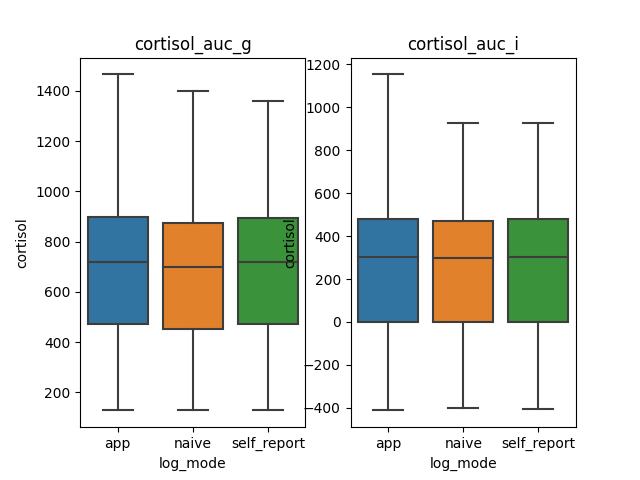

In [13]:
fig2, (ax1, ax2) = plt.subplots(1,2)

sns.boxplot(x='log_mode', y='cortisol', data=cort_feat_balanced.query("saliva_feature == 'cortisol_auc_g'"), ax = ax1)
ax1.set_title('cortisol_auc_g')

sns.boxplot(x='log_mode', y='cortisol', data=cort_feat_balanced.query("saliva_feature == 'cortisol_auc_i'"), ax = ax2)
ax2.set_title('cortisol_auc_i')

plt.show()

<AxesSubplot:xlabel='log_mode', ylabel='cortisol'>

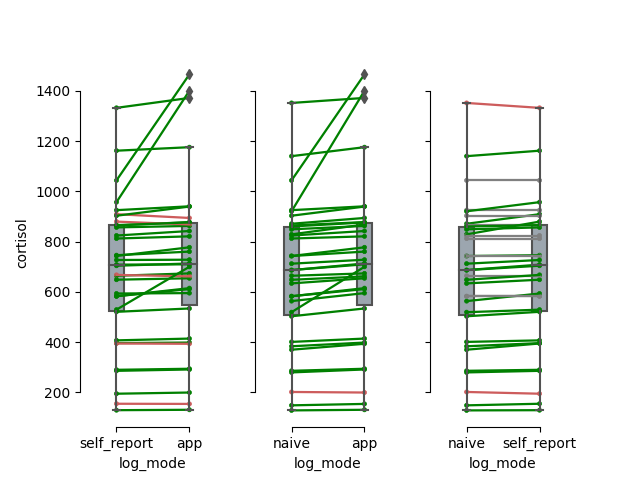

In [21]:
fig, axs = plt.subplots(1,3, sharey=True)

cort_auc_g_only = cort_feat_balanced.query("saliva_feature == 'cortisol_auc_g'") 

pg.plot_paired(cort_auc_g_only.query("log_mode != 'naive'"), dv="cortisol", within="log_mode", subject="subject", order=['self_report', 'app'], ax = axs[0])
pg.plot_paired(cort_auc_g_only.query("log_mode != 'self_report'"), dv="cortisol", within="log_mode", subject="subject", order=['naive', 'app'], ax = axs[1])
pg.plot_paired(cort_auc_g_only.query("log_mode != 'app'"), dv="cortisol", within="log_mode", subject="subject", order=['naive', 'self_report'], ax = axs[2])

In [9]:
steps = [("prep", "normality"), ("prep", "equal_var"), ("test", "rm_anova"), ("posthoc", "pairwise_ttests")]
params = {"groupby": "saliva_feature", "dv": "cortisol", "within": "log_mode", "subject": "subject", "padjust": "bonf"}
pipeline = StatsPipeline(steps=steps, params=params)

pipeline.apply(cort_feat_balanced)
pipeline.display_results()

C:\Users\Luca\anaconda3\envs\fp\lib\site-packages\pingouin\distribution.py:950: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d
C:\Users\Luca\anaconda3\envs\fp\lib\site-packages\pingouin\distribution.py:686: RuntimeWarning: invalid value encountered in double_scalars
  eps = np.min([num / den, 1])
C:\Users\Luca\anaconda3\envs\fp\lib\site-packages\pingouin\parametric.py:564: RuntimeWarning: divide by zero encountered in double_scalars
  fval = ms_with / ms_reswith
C:\Users\Luca\anaconda3\envs\fp\lib\site-packages\pingouin\parametric.py:232: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")


<font size="3"><b> Overview </b></font>

,groupby,dv,within,subject,padjust
parameter,saliva_feature,cortisol,log_mode,subject,bonf


,prep,prep,test,posthoc
parameter,normality,equal_var,rm_anova,pairwise_ttests


<font size="3"><b> Preparatory Analysis </b></font>

**Test for Normal Distribution**

W      pval  normal
saliva_feature                                            
cortisol_auc_g     app          0.968031  0.192254    True
                   naive        0.980611  0.578006    True
                   self_report  0.977984  0.470450    True
cortisol_auc_i     app          0.985312  0.784929    True
                   naive        0.984264  0.739558    True
                   self_report  0.984683  0.757878    True
cortisol_cini      app          0.865397  0.000042   False
                   naive        0.865397  0.000042   False
                   self_report  0.865397  0.000042   False
cortisol_cmax      app          0.980274  0.563584    True
                   naive        0.980274  0.563584    True
                   self_report  0.980274  0.563584    True
cortisol_max_inc   app          0.969311  0.216968    True
                   naive        0.969311  0.216968    True
                   self_report  0.969311  0.216968    True
cortisol_slopeS0S3 app          0.963884  0.129286    True
                   naive        0.957978  0.073144    True
                   self_report  0.951192  0.038195   False
cortisol_slopeS0S4 app          0.956182  0.061534    True
                   naive        0.948192  0.028766   False
                   self_report  0.944563  0.020494   False

**Test for Homoscedasticity (Equal Variances)**

,,W,pval,equal_var
saliva_feature,,,,
cortisol_auc_g,levene,0.132592,0.875927,True
cortisol_auc_i,levene,0.117542,0.889187,True
cortisol_cini,levene,0.000000,1.000000,True
cortisol_cmax,levene,0.000000,1.000000,True
cortisol_max_inc,levene,0.000000,1.000000,True
cortisol_slopeS0S3,levene,0.096110,0.908421,True
cortisol_slopeS0S4,levene,0.074714,0.928044,True


<font size="3"><b> Statistical Tests </b></font>

**Repeated-measurement ANOVA**

,,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
saliva_feature,,,,,,,,,,,,
cortisol_auc_g,0,log_mode,2,66,6.244827e+00,0.003282,0.016825,1.591248e-01,0.513516,False,0.052639,3.475021e-21
cortisol_auc_i,0,log_mode,2,66,3.300519e+00,0.043036,0.077915,9.092210e-02,0.504914,False,0.019465,4.246773e-28
cortisol_cini,0,log_mode,2,66,-0.000000e+00,1.000000,NaN,-0.000000e+00,NaN,NaN,NaN,NaN
cortisol_cmax,0,log_mode,2,66,inf,0.000000,NaN,1.000000e+00,NaN,NaN,NaN,NaN
cortisol_max_inc,0,log_mode,2,66,2.919540e-15,1.000000,NaN,8.847090e-17,NaN,NaN,NaN,NaN
cortisol_slopeS0S3,0,log_mode,2,66,3.090440e+00,0.052122,NaN,8.563044e-02,0.508587,NaN,NaN,NaN
cortisol_slopeS0S4,0,log_mode,2,66,2.537518e+00,0.086753,NaN,7.140391e-02,0.504906,NaN,NaN,NaN


<font size="3"><b> Post-Hoc Analysis </b></font>

**Pairwise t-Tests**

Contrast      A            B  Paired  Parametric  \
saliva_feature                                                           
cortisol_auc_g     0  log_mode    app        naive    True        True   
                   1  log_mode    app  self_report    True        True   
                   2  log_mode  naive  self_report    True        True   
cortisol_auc_i     0  log_mode    app        naive    True        True   
                   1  log_mode    app  self_report    True        True   
                   2  log_mode  naive  self_report    True        True   
cortisol_cini      0  log_mode    app        naive    True        True   
                   1  log_mode    app  self_report    True        True   
                   2  log_mode  naive  self_report    True        True   
cortisol_cmax      0  log_mode    app        naive    True        True   
                   1  log_mode    app  self_report    True        True   
                   2  log_mode  naive  self_report    True        True   
cortisol_max_inc   0  log_mode    app        naive    True        True   
                   1  log_mode    app  self_report    True        True   
                   2  log_mode  naive  self_report    True        True   
cortisol_slopeS0S3 0  log_mode    app        naive    True        True   
                   1  log_mode    app  self_report    True        True   
                   2  log_mode  naive  self_report    True        True   
cortisol_slopeS0S4 0  log_mode    app        naive    True        True   
                   1  log_mode    app  self_report    True        True   
                   2  log_mode  naive  self_report    True        True   

                             T   dof alternative     p-unc    p-corr p-adjust  \
saliva_feature                                                                  
cortisol_auc_g     0  2.718089  33.0   two-sided  0.010381  0.031143     bonf   
                   1  2.203704  33.0   two-sided  0.034632  0.103895     bonf   
                   2 -4.137401  33.0   two-sided  0.000227  0.000682     bonf   
cortisol_auc_i     0  1.882450  33.0   two-sided  0.068617  0.205852     bonf   
                   1  1.742188  33.0   two-sided  0.090790  0.272370     bonf   
                   2 -2.173626  33.0   two-sided  0.037010  0.111029     bonf   
cortisol_cini      0       NaN  33.0   two-sided       NaN       NaN     bonf   
                   1       NaN  33.0   two-sided       NaN       NaN     bonf   
                   2       NaN  33.0   two-sided       NaN       NaN     bonf   
cortisol_cmax      0       NaN  33.0   two-sided       NaN       NaN     bonf   
                   1       NaN  33.0   two-sided       NaN       NaN     bonf   
                   2       NaN  33.0   two-sided       NaN       NaN     bonf   
cortisol_max_inc   0       NaN  33.0   two-sided       NaN       NaN     bonf   
                   1       NaN  33.0   two-sided       NaN       NaN     bonf   
                   2       NaN  33.0   two-sided       NaN       NaN     bonf   
cortisol_slopeS0S3 0 -1.753674  33.0   two-sided  0.088771  0.266314     bonf   
                   1 -1.773735  33.0   two-sided  0.085336  0.256008     bonf   
                   2  0.445027  33.0   two-sided  0.659206  1.000000     bonf   
cortisol_slopeS0S4 0 -1.536008  33.0   two-sided  0.134070  0.402210     bonf   
                   1 -1.665934  33.0   two-sided  0.105193  0.315578     bonf   
                   2 -0.133542  33.0   two-sided  0.894575  1.000000     bonf   

                         BF10    hedges  
saliva_feature                           
cortisol_auc_g     0    4.181  0.159276  
                   1    1.533  0.126695  
                   2  120.259 -0.035248  
cortisol_auc_i     0    0.888  0.077945  
                   1    0.715  0.070356  
                   2    1.453 -0.008057  
cortisol_cini      0      nan  0.000000  
                   1      nan  0.000000  
                   2      nan  0.00